In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from scipy.stats import uniform
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
pd.set_option('display.max_rows', 100,'display.max_columns',100)

# EDA 

In [2]:
data=pd.read_csv("loandata.csv")
df=data.copy()

In [3]:
cols_to_drop = [
    # unique id
    'id'
    , 'member_id'
    , 'Unnamed: 0'
    , "application_type"
    
    # free text
    , 'url'
    , 'desc'
    
    # all null / constant / others
    , 'zip_code' 
    , 'annual_inc_joint'
    , 'dti_joint'
    , 'verification_status_joint'
    , 'open_acc_6m'
    , 'open_il_6m'
    , 'open_il_12m'
    , 'open_il_24m'
    , 'mths_since_rcnt_il'
    , 'total_bal_il'
    , 'il_util'
    , 'open_rv_12m'
    , 'open_rv_24m'
    , 'max_bal_bc'
    , 'all_util'
    , 'inq_fi'
    , 'total_cu_tl'
    , 'inq_last_12m'
    
    # expert judgment
    , 'sub_grade'
]




df=df.drop(columns=cols_to_drop, axis=1)

In [4]:
num_dtypes = [ 'int64',  'float64']
num_df = df.select_dtypes(include=num_dtypes)
num = num_df.columns
num_df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,NaN,1,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,NaN,1,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,0.00,0.00,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,NaN,1,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,0.00,0.00,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,NaN,1,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,NaN,1,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,14.47,432.64,110000.0,19.85,0.0,2.0,NaN,NaN,18.0,0.0,23208,77.6,36.0,12574.00,12574.00,10383.360000,10383.36,5826.00,4557.36,0.00,0.00,0.00,432.64,0.0,NaN,1,0.0,0.0,294998.0,29900.0
466281,22000,22000,22000.0,19.97,582.50,78000.0,18.45,0.0,5.0,NaN,116.0,18.0,1.0,18238,46.3,30.0,0.00,0.00,4677.920000,4677.92,1837.04,2840.88,0.00,0.00,0.00,17.50,0.0,NaN,1,0.0,0.0,221830.0,39400.0
466282,20700,20700,20700.0,16.99,514.34,46000.0,25.65,0.0,2.0,65.0,NaN,18.0,0.0,6688,51.1,43.0,14428.31,14428.31,12343.980000,12343.98,6271.69,6072.29,0.00,0.00,0.00,514.34,0.0,NaN,1,0.0,0.0,73598.0,13100.0
466283,2000,2000,2000.0,7.90,62.59,83000.0,5.39,3.0,1.0,13.0,NaN,21.0,0.0,11404,21.5,27.0,0.00,0.00,2126.579838,2126.58,2000.00,126.58,0.00,0.00,0.00,1500.68,0.0,NaN,1,0.0,0.0,591610.0,53100.0


In [5]:
cat_type=["object"]
cat_type_df=df.select_dtypes(include=cat_type)
cat=cat_type_df.columns
cat_type_df

,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,36 months,B,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,n,credit_card,Computer,AZ,Jan-85,f,Jan-15,NaN,Jan-16
1,60 months,C,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,car,bike,GA,Apr-99,f,Apr-13,NaN,Sep-13
2,36 months,C,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,n,small_business,real estate business,IL,Nov-01,f,Jun-14,NaN,Jan-16
3,36 months,C,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Fully Paid,n,other,personel,CA,Feb-96,f,Jan-15,NaN,Jan-15
4,60 months,B,University Medical Group,1 year,RENT,Source Verified,Dec-11,Current,n,other,Personal,OR,Jan-96,f,Jan-16,Feb-16,Jan-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,60 months,C,Financial Advisor,4 years,MORTGAGE,Source Verified,Jan-14,Current,n,debt_consolidation,Debt consolidation,TX,Apr-03,w,Jan-16,Feb-16,Jan-16
466281,60 months,D,Chief of Interpretation (Park Ranger),10+ years,MORTGAGE,Verified,Jan-14,Charged Off,n,debt_consolidation,Debt consolidation,TN,Jun-97,f,Dec-14,NaN,Jan-16
466282,60 months,D,patrol,7 years,MORTGAGE,Verified,Jan-14,Current,n,debt_consolidation,Debt consolidation,OH,Dec-01,f,Jan-16,Feb-16,Dec-15
466283,36 months,A,Server Engineer Lead,3 years,OWN,Verified,Jan-14,Fully Paid,n,credit_card,Credit card refinancing,CA,Feb-03,w,Dec-14,NaN,Apr-15


In [6]:
for x in df.select_dtypes(include=[ 'int64',  'float64']):
    print(df[[x]].nunique())
    


loan_amnt    1352
dtype: int64
funded_amnt    1354
dtype: int64
funded_amnt_inv    9854
dtype: int64
int_rate    506
dtype: int64
installment    55622
dtype: int64
annual_inc    31901
dtype: int64
dti    3997
dtype: int64
delinq_2yrs    24
dtype: int64
inq_last_6mths    28
dtype: int64
mths_since_last_delinq    145
dtype: int64
mths_since_last_record    123
dtype: int64
open_acc    62
dtype: int64
pub_rec    26
dtype: int64
revol_bal    58142
dtype: int64
revol_util    1269
dtype: int64
total_acc    112
dtype: int64
out_prncp    135665
dtype: int64
out_prncp_inv    141189
dtype: int64
total_pymnt    351609
dtype: int64
total_pymnt_inv    347659
dtype: int64
total_rec_prncp    172713
dtype: int64
total_rec_int    270249
dtype: int64
total_rec_late_fee    5808
dtype: int64
recoveries    22773
dtype: int64
collection_recovery_fee    20275
dtype: int64
last_pymnt_amnt    198194
dtype: int64
collections_12_mths_ex_med    9
dtype: int64
mths_since_last_major_derog    162
dtype: int64
policy_

## Penentuan Target (Loan Status)
- Karena loan_status mencerminkan data pada tiap customer maka akan digunakan sebagai data target

In [7]:
df.loan_status.value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

### Bikin target data dengan nama kolom (bad_status_target)


In [8]:
bad_status = [
    'Charged Off' 
    , 'Default' 
    , 'Does not meet the credit policy. Status:Charged Off'
    , 'Late (31-120 days)'
]


# df["bad_status_target"]= np.where(df["loan_status"].isin(bad_status),1,0)

df['bad_status_target'] = df['loan_status'].isin(bad_status).map({True: 1, False: 0})

#### Imbalance data

In [9]:
df.bad_status_target.value_counts()

bad_status_target
0    415317
1     50968
Name: count, dtype: int64

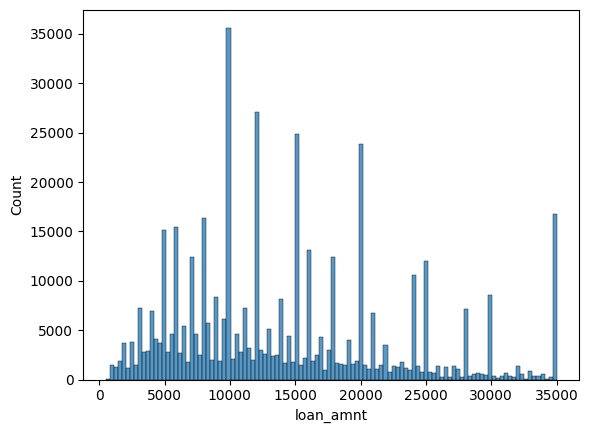

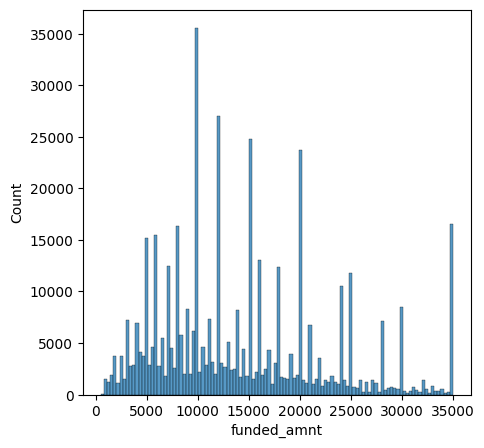

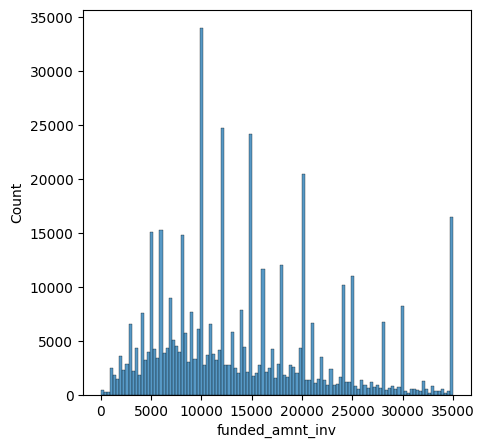

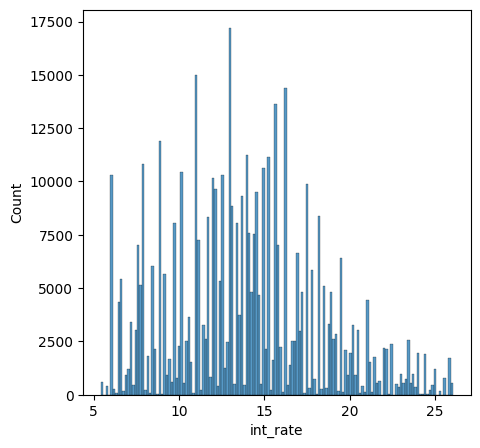

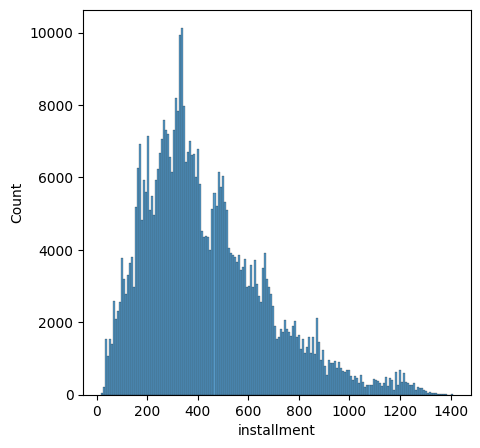

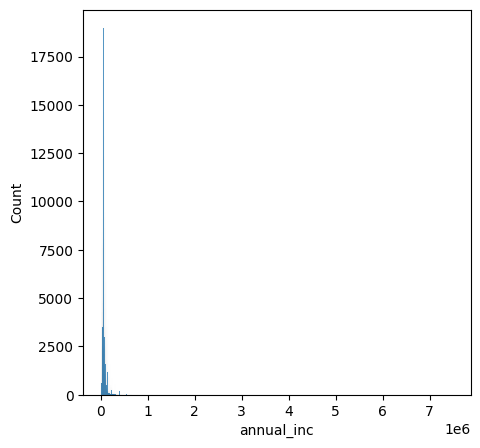

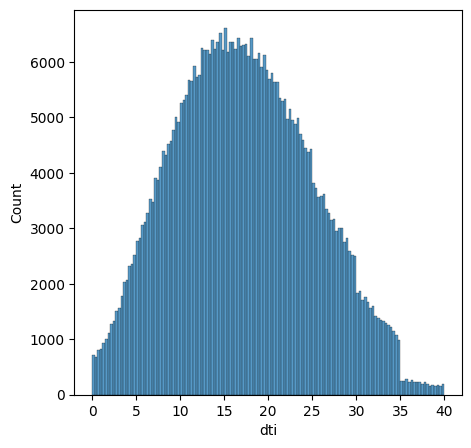

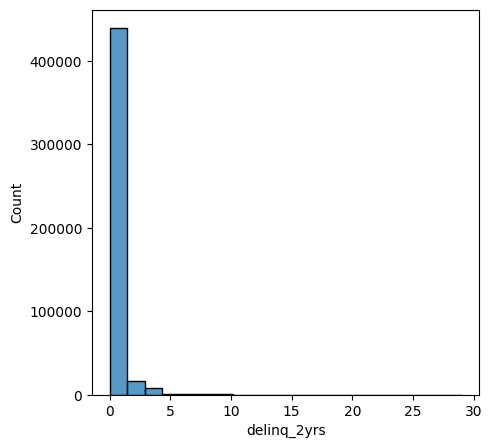

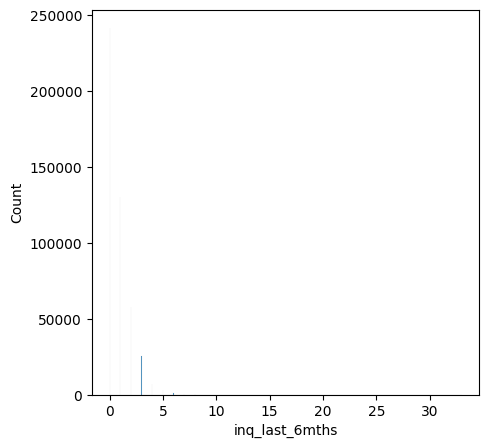

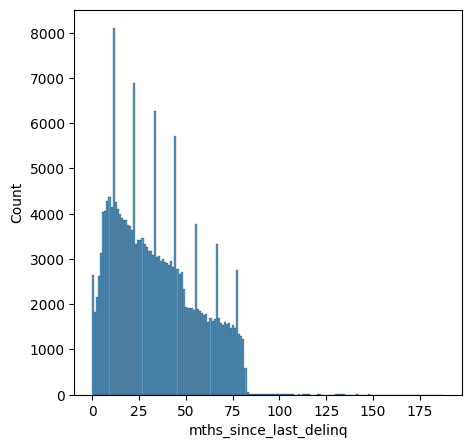

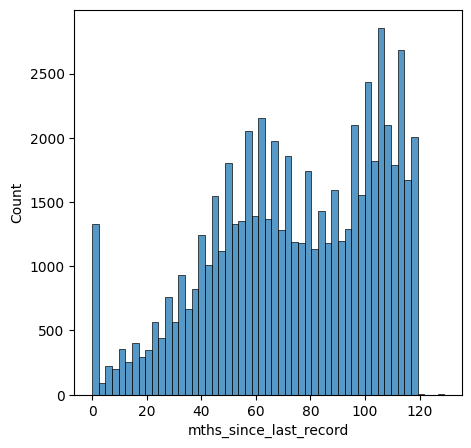

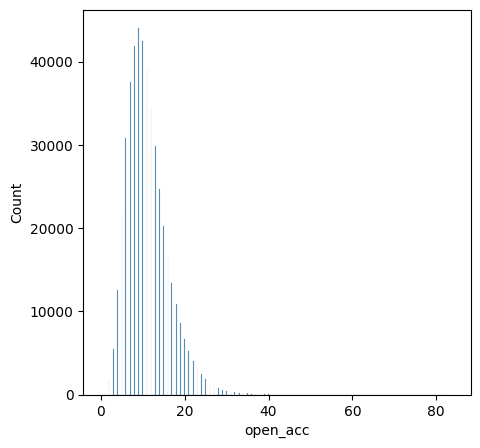

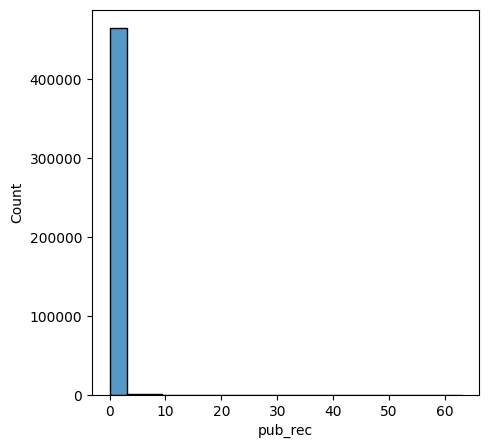

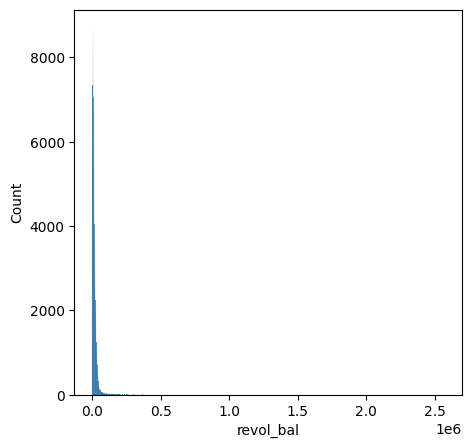

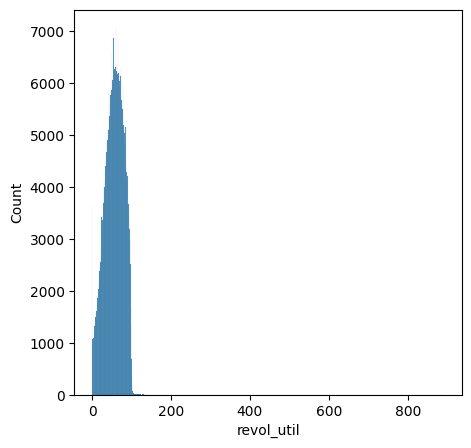

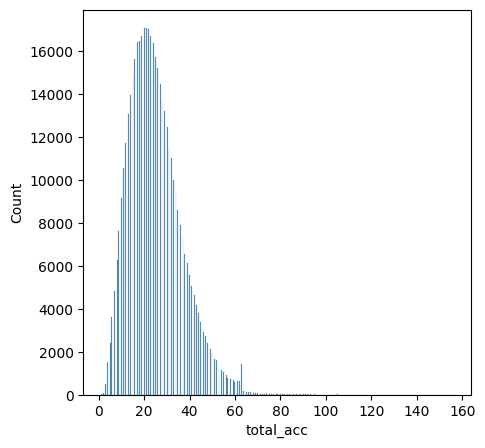

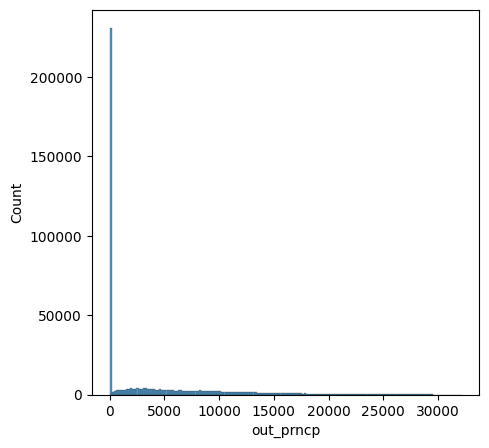

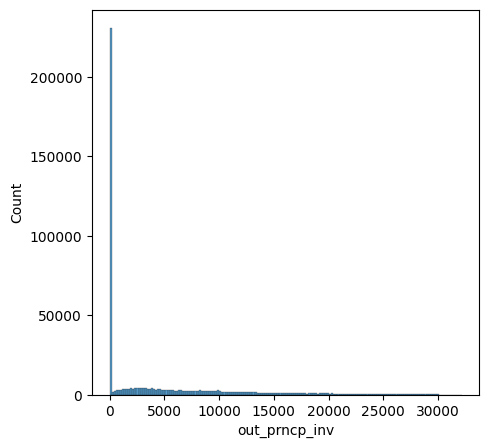

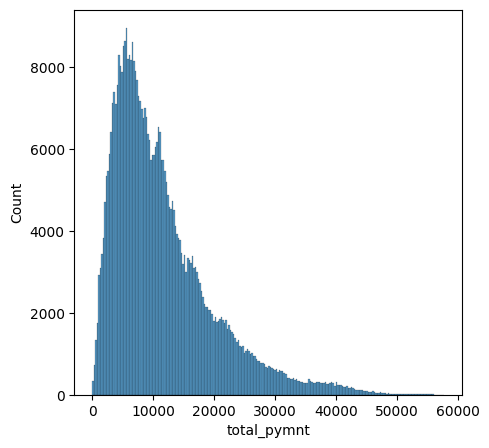

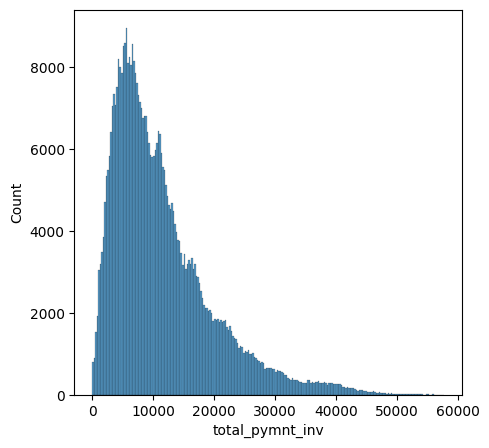

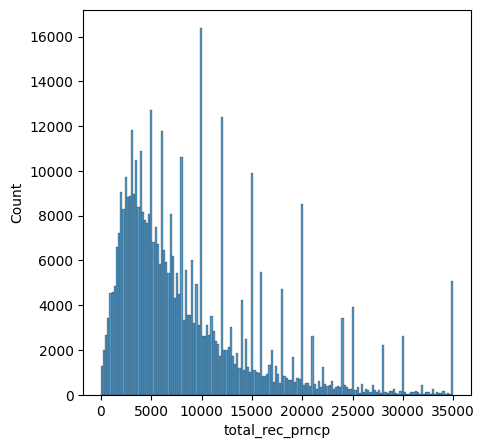

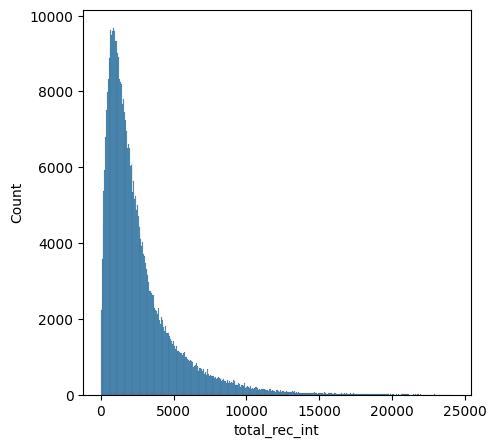

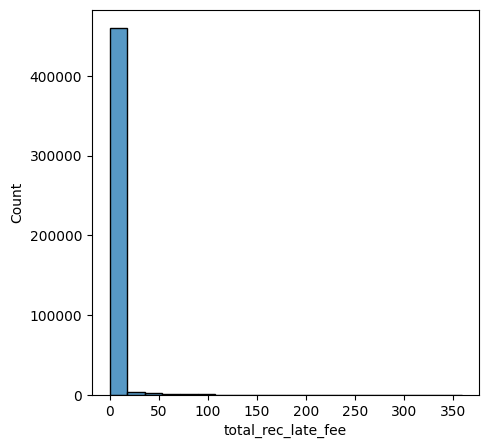

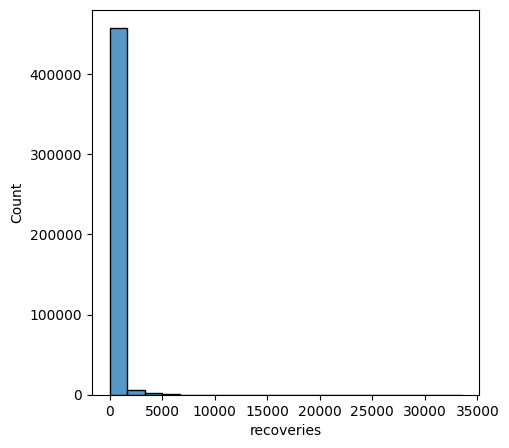

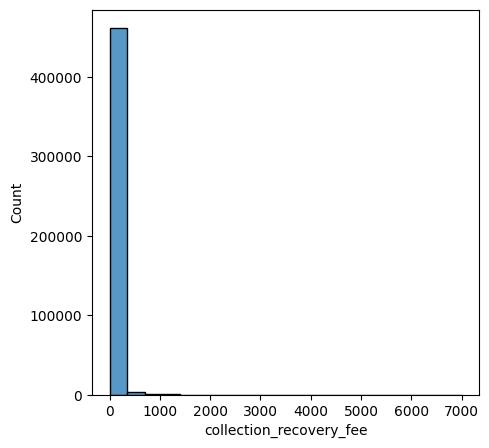

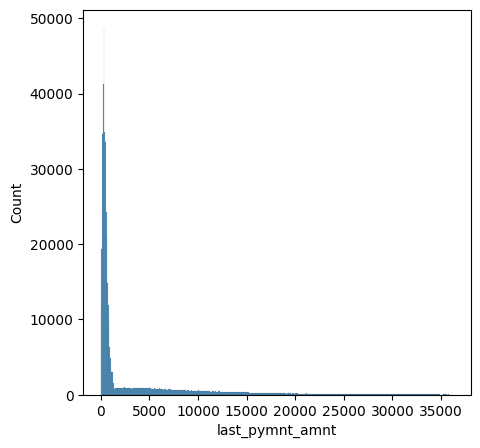

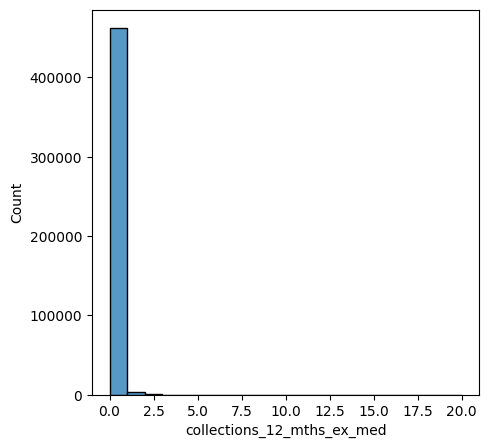

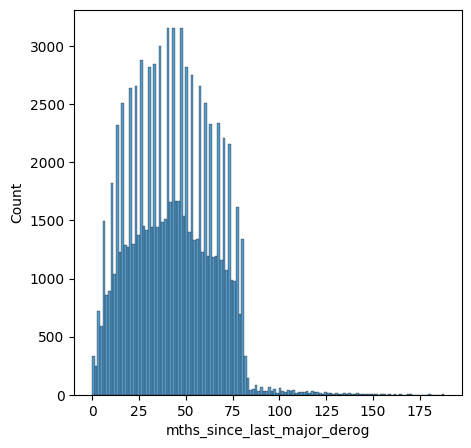

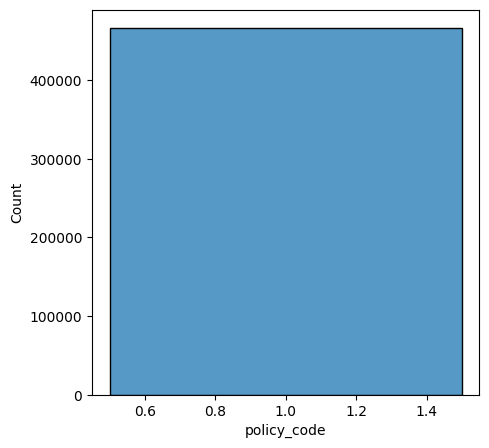

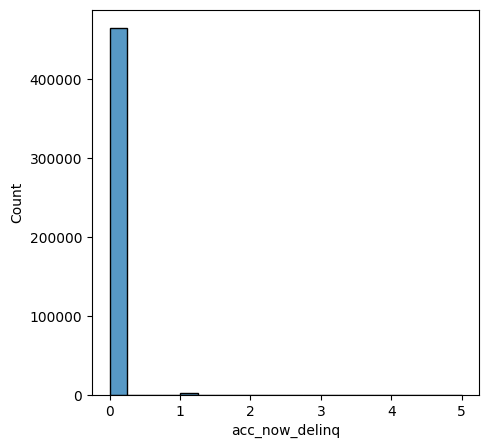

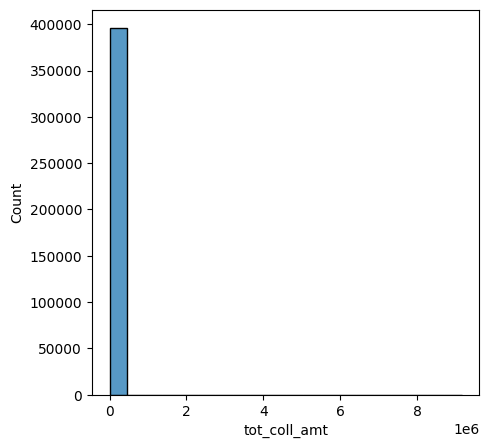

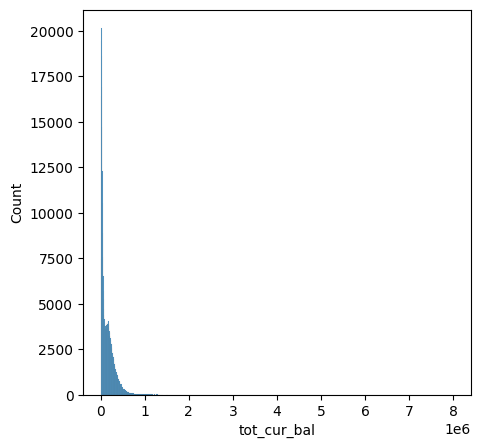

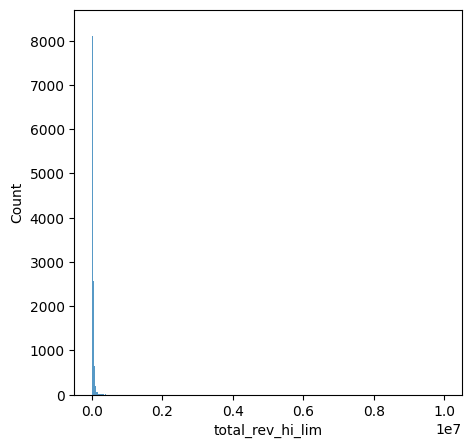

<Figure size 500x500 with 0 Axes>

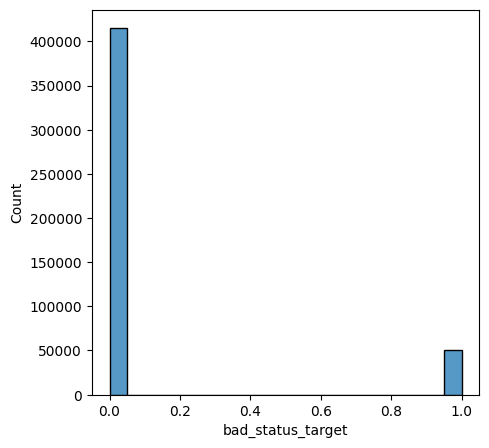

In [10]:
"""Numeric data type"""
for i, col in enumerate(df._get_numeric_data()):
    plt.figure(figsize=(5,5))   
    plt.figure(i)
    sns.histplot(df[col])


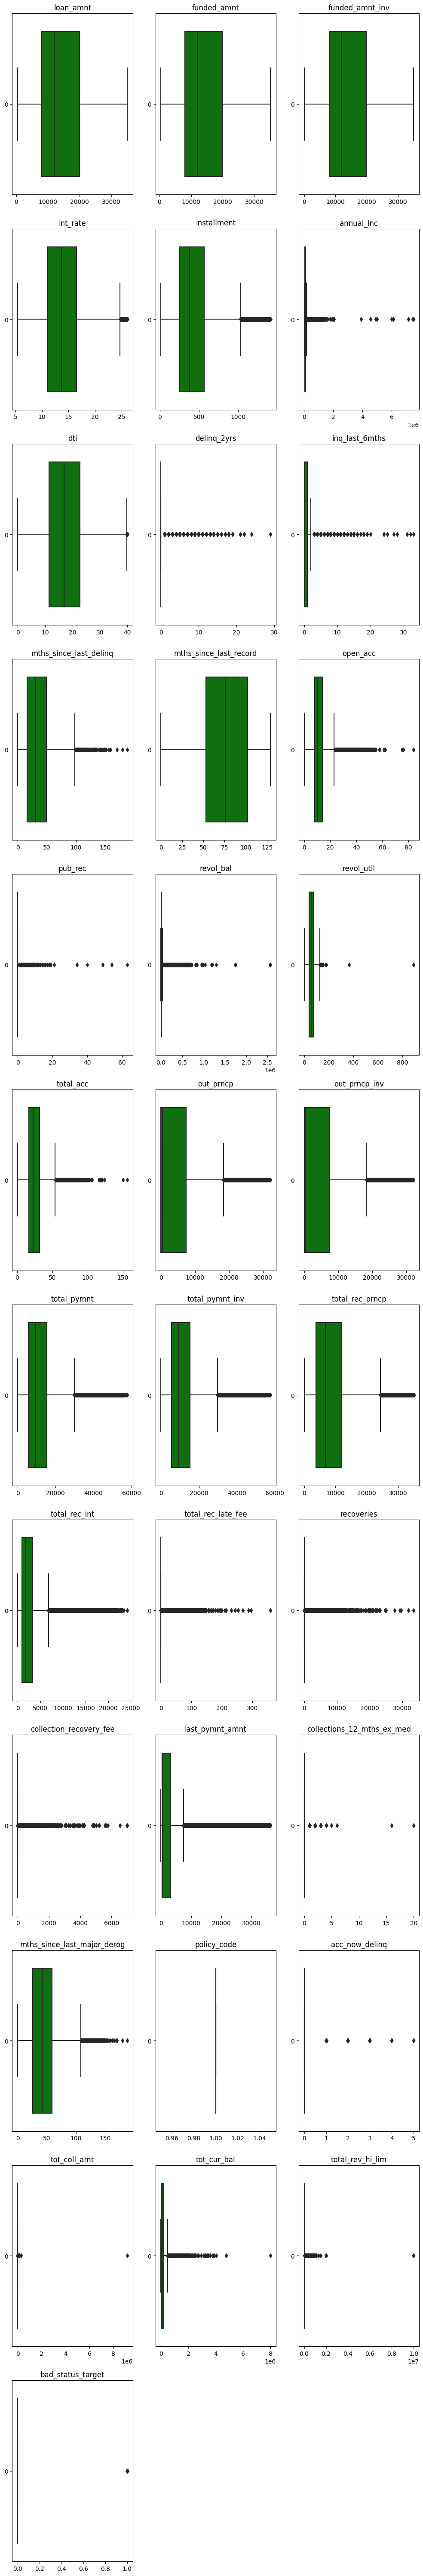

In [11]:

n_cols = 3
n_rows = (len(df._get_numeric_data().columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 5*n_rows))

for i, ax in enumerate(axes.flatten()):
    if i < len(df._get_numeric_data().columns):
        col = df._get_numeric_data().columns[i]
        sns.boxplot(data=df._get_numeric_data()[col], color='green', orient="h", ax=ax)
        ax.set_title(col)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
  

# Cleaning Feature etc


### Emp_Length

In [12]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [13]:
df['emp_length_int'] = df['emp_length'].str.replace('+ years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1 year', str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace(' years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace(' year', '')


In [14]:
df['emp_length_int'] = df['emp_length_int'].astype(float)
df.drop('emp_length', axis=1, inplace=True)

### term

Memodifikasi `term`. Contoh: 36 months -> 36

In [15]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [16]:
df['term_int'] = df['term'].str.replace(' months', '')
df['term_int'] = df['term_int'].astype(float)

In [17]:
df.drop('term', axis=1, inplace=True)

### earliest_cr_line

To modify the 'earliest_cr_line' column from a month-year format to the calculation of how much time has passed since that date, it is common to use a reference date, usually the current date. However, since the dataset ranges from 2007 to 2014, it would be more relevant to use a reference date around 2017. In this example, let's use the date '2017-12-01' as the reference date.

In [18]:
df['earliest_cr_line'].head(3)

0    Jan-85
1    Apr-99
2    Nov-01
Name: earliest_cr_line, dtype: object

In [19]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [20]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
df['mths_since_earliest_cr_line'].head(3)

0    388.0
1    220.0
2    189.0
Name: mths_since_earliest_cr_line, dtype: float64

In [21]:
df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        235.142031
std          92.270010
min        -601.000000
25%         180.000000
50%         221.000000
75%         280.000000
max         576.000000
Name: mths_since_earliest_cr_line, dtype: float64

Terlihat ada nilai yang aneh, yaitu negatif.

In [22]:
df[df['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-527.0
1770,Sep-68,2068-09-01,-598.0
2799,Sep-64,2064-09-01,-551.0


It appears that the negative values occur because the Python function incorrectly interprets the year '62' as '2062', whereas it should be '1962'.

To address this, further preprocessing can be done to correct the year 2062 to 1962. However, in this case, you only want to change the negative values to the maximum value of that feature. Since you know that negative values represent old data (in the 1900s), it makes sense to replace those values with the maximum value.

In [23]:
df.loc[df['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = df['mths_since_earliest_cr_line'].max()

In [24]:
df.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1, inplace=True)

### issue_d

In [25]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['issue_d_date']) / np.timedelta64(1, 'M')))

In [26]:
df['mths_since_issue_d'].describe()

count    466285.000000
mean         50.204806
std          14.190212
min          35.000000
25%          40.000000
50%          46.000000
75%          56.000000
max         124.000000
Name: mths_since_issue_d, dtype: float64

In [27]:
df.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

### last_pymnt_d

In [28]:
df['last_pymnt_d_date'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [29]:
df['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         30.916097
std          12.406823
min          23.000000
25%          23.000000
50%          24.000000
75%          34.000000
max         118.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [30]:
df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

### next_pymnt_d

In [31]:
df['next_pymnt_d_date'] = pd.to_datetime(df['next_pymnt_d'], format='%b-%y')
df['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [32]:
df['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.722279
std           5.928592
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         118.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [33]:
df.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1, inplace=True)

### last_credit_pull_d

In [34]:
df['last_credit_pull_d_date'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [35]:
df['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         26.856223
std           9.303991
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         125.000000
Name: mths_since_last_credit_pull_d, dtype: float64

# HeatMap And Dumping Some Features

<Axes: >

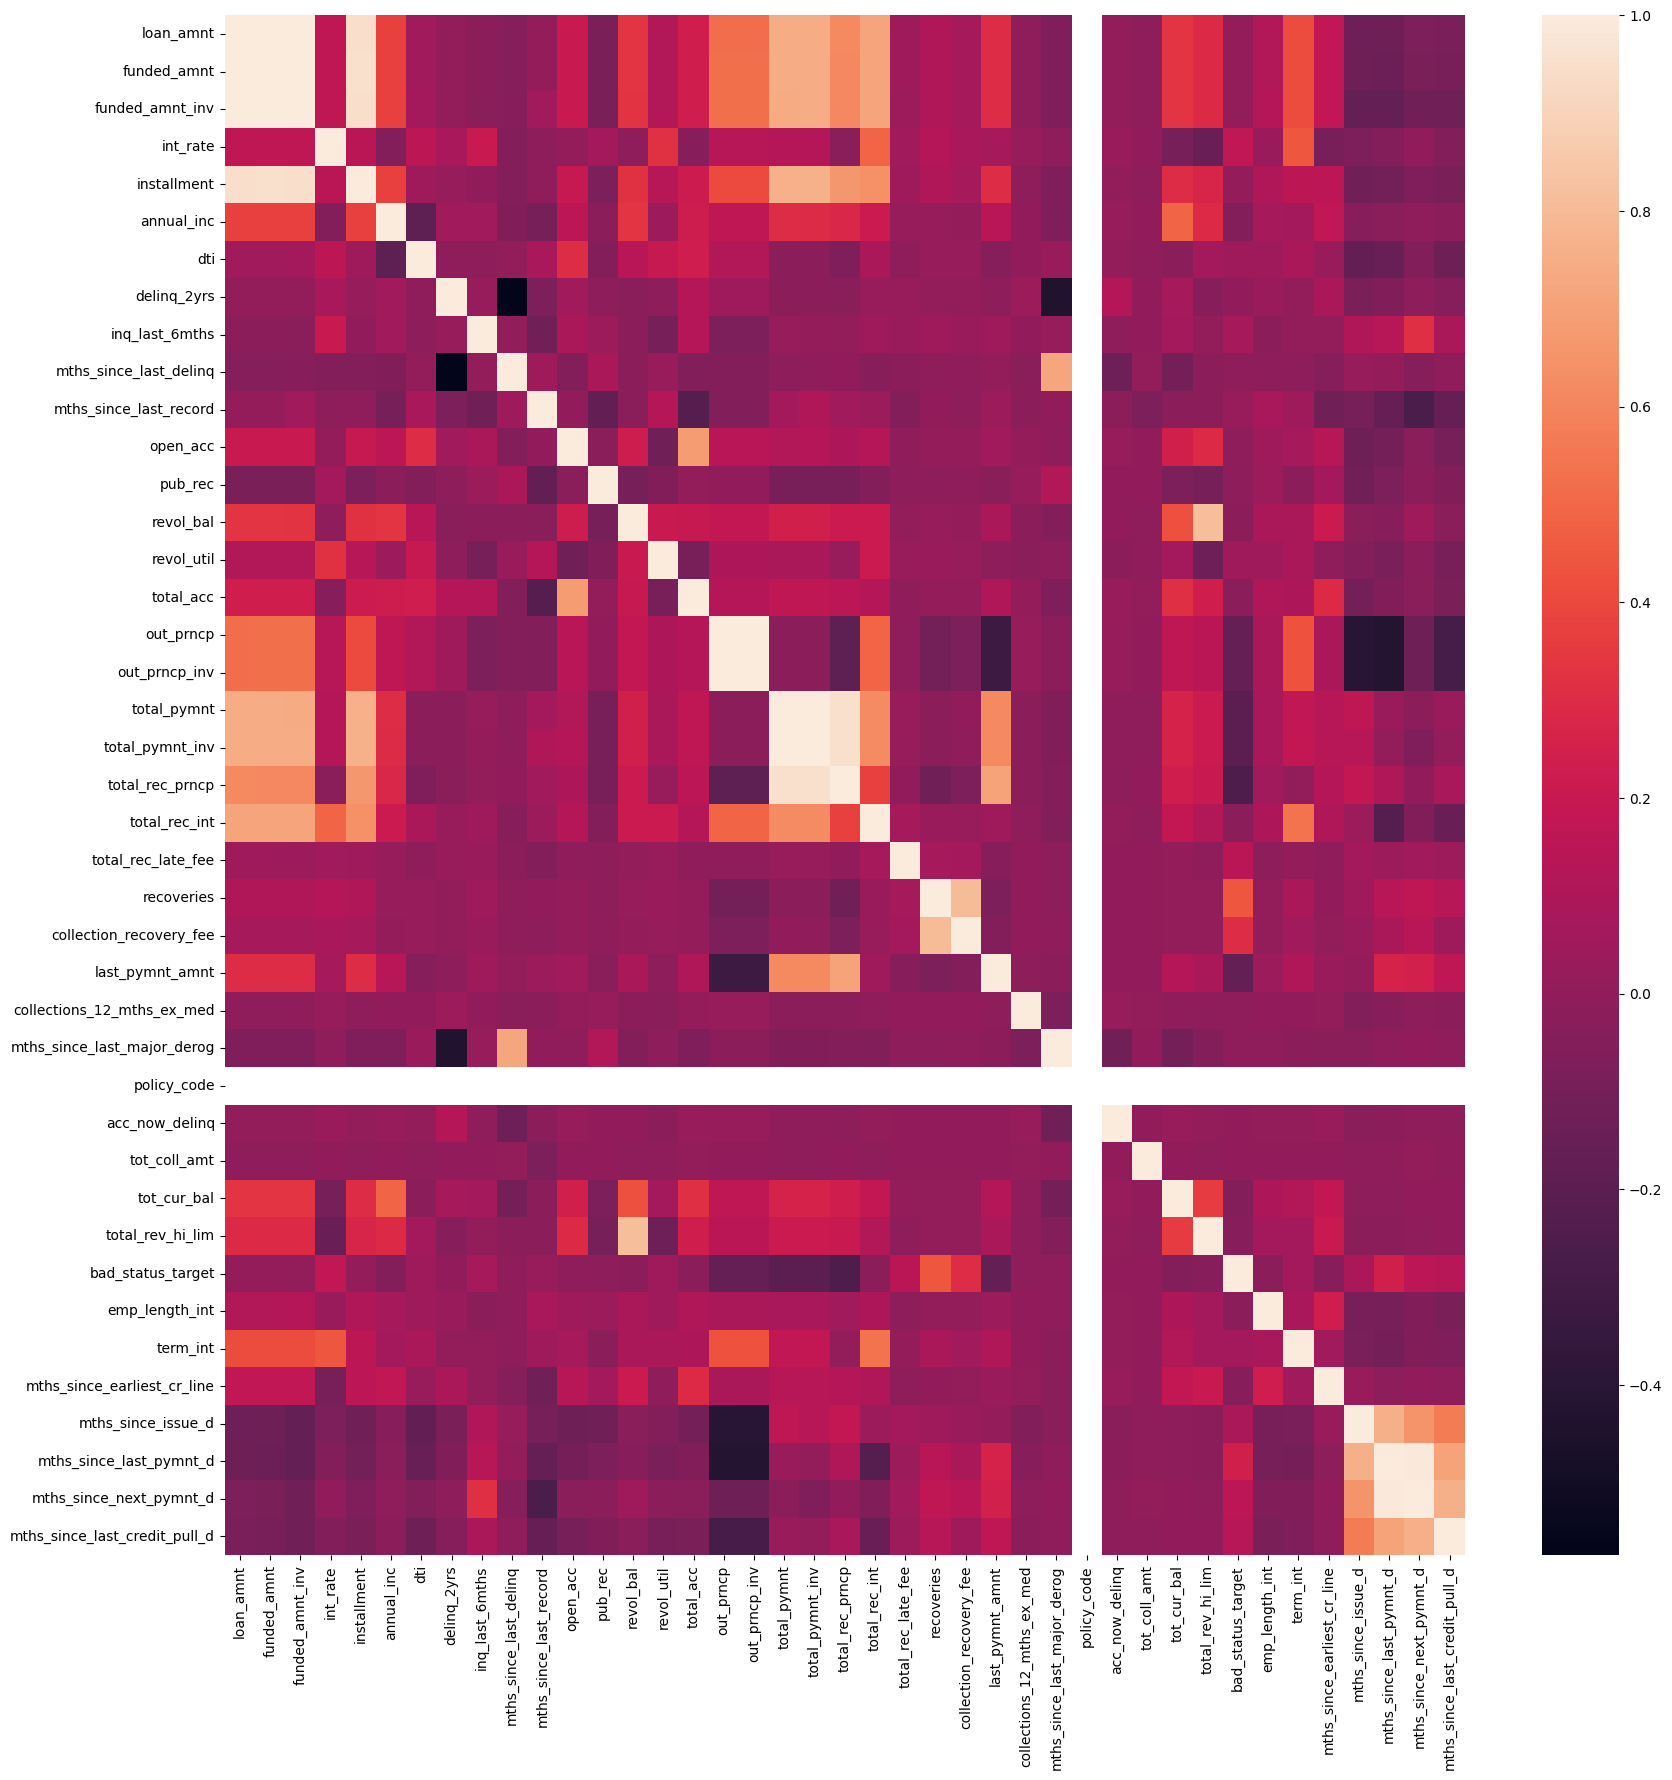

In [36]:
plt.figure(figsize=(20,20))
sns.heatmap(df._get_numeric_data().corr())

In [37]:
"""drop the column with >0.7"""

corr_matrix = df._get_numeric_data().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(dtype=bool))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop_hicorr)
df._get_numeric_data().drop(to_drop_hicorr, axis=1, inplace=True)

['funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'policy_code', 'bad_status_target', 'emp_length_int', 'term_int', 'mths_since_earliest_cr_line', 'mths_since_issue_d', 'mths_since_last_pymnt_d', 'mths_since_next_pymnt_d', 'mths_since_last_credit_pull_d']


In [38]:
df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

### Check Categorical Features

In [39]:
df.select_dtypes(include='object').nunique()


df.drop(['emp_title', 'title',"policy_code"], axis=1, inplace=True)

### Missing Values Checking

In [40]:
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)






mths_since_last_record           86.566585
mths_since_last_major_derog      78.773926
mths_since_last_delinq           53.690554
mths_since_next_pymnt_d          48.728567
tot_coll_amt                     15.071469
total_rev_hi_lim                 15.071469
tot_cur_bal                      15.071469
emp_length_int                    4.505399
mths_since_last_pymnt_d           0.080637
revol_util                        0.072917
collections_12_mths_ex_med        0.031097
mths_since_last_credit_pull_d     0.009007
acc_now_delinq                    0.006219
delinq_2yrs                       0.006219
total_acc                         0.006219
pub_rec                           0.006219
mths_since_earliest_cr_line       0.006219
open_acc                          0.006219
inq_last_6mths                    0.006219
annual_inc                        0.000858
dtype: float64

In [41]:
df.drop('mths_since_last_record', axis=1, inplace=True)

### Missing Values Filling

In [42]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['collections_12_mths_ex_med'].fillna(0, inplace=True)
df['revol_util'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)
df['tot_cur_bal'].fillna(0, inplace=True)
df['tot_coll_amt'].fillna(0, inplace=True)
df['mths_since_last_delinq'].fillna(-1, inplace=True)

In [43]:
df.isnull().sum()

loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
int_rate                              0
installment                           0
grade                                 0
home_ownership                        0
annual_inc                            0
verification_status                   0
loan_status                           0
pymnt_plan                            0
purpose                               0
addr_state                            0
dti                                   0
delinq_2yrs                           0
inq_last_6mths                        0
mths_since_last_delinq                0
open_acc                              0
pub_rec                               0
revol_bal                             0
revol_util                            0
total_acc                             0
initial_list_status                   0
out_prncp                             0
out_prncp_inv                         0


In [44]:
df.drop(["mths_since_last_pymnt_d","mths_since_last_credit_pull_d","mths_since_last_major_derog","total_rev_hi_lim"], axis=1, inplace=True)

In [45]:
df.drop("mths_since_next_pymnt_d",axis=1,inplace=True)

# FEATURE SCALING AND TRANSFORMATION

### One Hot Encoding


One Hot Encoding.

In [46]:
categorical_cols = [col for col in df.select_dtypes(include='object').columns.tolist()]

In [47]:
onehot = pd.get_dummies(df[categorical_cols], drop_first=True)

In [48]:
onehot.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,loan_status_Current,loan_status_Default,loan_status_Does not meet the credit policy. Status:Charged Off,loan_status_Does not meet the credit policy. Status:Fully Paid,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days),pymnt_plan_y,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
0,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,

### Standardization

all columns StandardScaler.

In [49]:
numerical_cols = [col for col in df.columns.tolist() if col not in categorical_cols + ['bad_status_target']]

In [50]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(df[numerical_cols]), columns=numerical_cols)

In [51]:
std.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,emp_length_int,term_int,mths_since_earliest_cr_line,mths_since_issue_d
0,-1.124392,-1.122963,-1.114455,-0.729587,-1.105575,-0.896551,1.328632,-0.357012,0.178920,-0.708792,-1.641166,-0.31429,-0.124888,1.159498,-1.384557,-0.693944,-0.693896,-0.687137,-0.683064,-0.549800,-0.695548,-0.123464,-0.154549,-0.104824,-0.531492,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,1.766910,1.465462
1,-1.426088,-1.425101,-1.412732,0.330634,-1.528763,-0.787387,-2.065791,-0.357012,3.843328,-0.708792,-1.641166,-0.31429,-0.703378,-1.965980,-1.815538,-0.693944,-0.693896,-1.274191,-1.267385,-1.195952,-0.867019,-0.123464,0.057470,-0.091840,-0.540846,-0.083608,-0.058307,-0.012089,-0.792648,-1.523744,1.622784,-0.211720,1.465462
2,-1.438156,-1.437186,-1.424784,0.488979,-1.428140,-1.110294,-1.082491,-0.357012,1.095022,-0.708792,-1.841641,-0.31429,-0.642003,1.782070,-1.298361,-0.693944,-0.693896,-1.032837,-1.025695,-0.919555,-0.799187,-0.123464,-0.154549,-0.104824,-0.445387,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,-0.576824,1.465462
3,-0.521001,-0.518687,-0.508860,-0.077850,-0.380931,-0.438063,0.354248,-0.357012,0.178920,0.860811,-0.237839,-0.31429,-0.514224,-1.478018,1.028934,-0.693944,-0.693896,0.082948,0.091640,0.161268,-0.152728,3.099264,-0.154549,-0.104824,-0.498032,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,0.224050,1.465462
4,-1.365749,-1.364673,-1.352474,-0.261438,-1.496071,0.122311,0.091865,-0.357012,-0.737182,0.991612,0.764538,-0.31429,0.558748,-0.094058,1.115130,-0.573268,-0.573185,-1.003980,-0.996798,-0.943290,-0.635962,-0.123464,-0.154549,-0.104824,-0.550184,-0.083608,-0.058307,-0.012089,-0.792648,-1.257509,1.622784,0.235828,1.465462


# Machine Learning

In [52]:
data_model = pd.concat([onehot, std, df[['bad_status_target']]], axis=1)

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred,average='micro'))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred,average='micro'))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred,average='micro'))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) 
    print("AUC: %.2f" % auc(fpr, tpr))

In [63]:
# Split Feature and Label
X = data_model.drop('bad_status_target', axis=1)
y = data_model['bad_status_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
X_train.shape, X_test.shape

((326399, 118), (139886, 118))

In [67]:
### Logistic 
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 1.00
Precision (Test Set): 1.00
Recall (Test Set): 1.00
F1-Score (Test Set): 1.00
AUC: 1.00


In [57]:
### Decision Tree
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier(random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model.predict(X_test)
eval_classification(model2, y_pred2, X_train, y_train, X_test, y_test)


Accuracy (Test Set): 1.00
Precision (Test Set): 1.00
Recall (Test Set): 1.00
F1-Score (Test Set): 1.00
AUC: 1.00


In [58]:
### Random forest
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier(random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model.predict(X_test)
eval_classification(model4, y_pred4, X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

### Proba Validation

In [60]:
y_pred_proba = model.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score

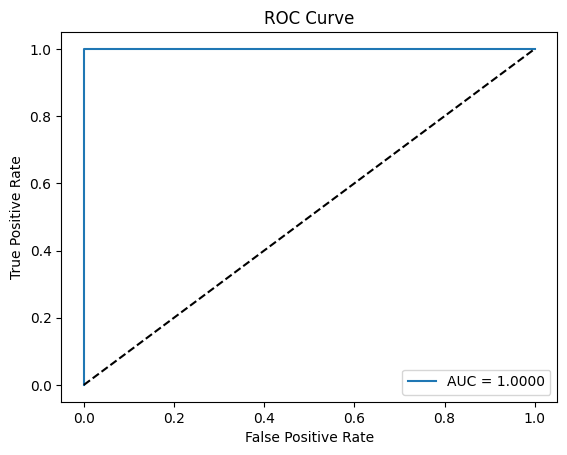

In [62]:
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()